In [1]:
import pandas as pd
import numpy as np
from ipynb.fs.defs.Preprocessing_Module import read_data, add_topological, add_landcover, select_columns, reshape_dataset, fillna_dataset
from ipynb.fs.defs.Feature_Expansion_Module import feature_expansion
from ipynb.fs.defs.Initializer_Module import initializer
from ipynb.fs.defs.XGBoost_Model_Module import Xgboost_model
from ipynb.fs.defs.Model_Validation_Module import test_model_random_split, train_model_KFold, operational_validation, predict

In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [3]:
data = read_data('../Datasets/Italy/Trentino/Aedes/IT_trentino_aedes_2011_2022.csv')
columns = ['dt_placement', 'x', 'y', 'aedes albopictus', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean','sex']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean','sex']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/Italy_trentino_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/Italy_trentino_2km_lulc.csv')
data = reshape_dataset(data,dupl_list=['x','y','dt_placement','sex'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})
del data['sex']
#=====================removal of stations with only zero mosquitoes=====================================
st = data[['x', 'y']].drop_duplicates().reset_index(drop=True)
drop_index = []
for i in range(len(st)):
    cc = data.loc[(data['x']==st.loc[i,'x']) & (data['y']==st.loc[i,'y'])].dropna(subset=['mosq_now'])
    if len(cc['mosq_now'].unique())==1:
        drop_index.append(i)
st = st.drop(drop_index).reset_index(drop=True)
data = pd.merge(data, st, how='inner', on = ['x','y']).reset_index(drop=True)

Index(['station_id', 'y', 'x', 'dt_placement', 'week', 'month', 'year',
       'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code', 'nuts1_name',
       'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type', 'aedes albopictus',
       'sex', 'region', 'dt_placement_original', 'indices_image_date',
       'indices_lat', 'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi',
       'ndvi_mean', 'ndmi_mean', 'ndwi_mean', 'ndbi_mean', 'ndvi_std',
       'ndmi_std', 'ndwi_std', 'ndbi_std', 'lst_image_date', 'lst_lat',
       'lst_lon', 'lst_day', 'lst_night', 'monthly_lst_lat', 'monthly_lst_lon',
       'lst_jan_day_mean', 'lst_jan_night_mean', 'lst_feb_day_mean',
       'lst_feb_night_mean', 'lst_mar_day_mean', 'lst_mar_night_mean',
       'lst_apr_day_mean', 'lst_apr_night_mean', 'indices_image_date.1',
       'indices_lat.1', 'indices_lon.1', 'acc_rainfall_jan',
       'dt_placement_minus_7', 'dt_placement_minus_14',
       'dt_pl

In [4]:
# set the only_env as True if you want to use only environmental features
only_env = False
# set the case title
case_title = 'Aedes Trentino'
# set the exp as True if you want to save the results as csv
exp = False
# set the filepath to export the data
path = '../Resuts/Culex Italy/'
# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'class_regression'
# set the transform argument as True if you want to limit the target variable to 0-9 scale
transform_target = False
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the transformation actions of the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = []

In [5]:
data = feature_expansion(data, env=only_env)

In [6]:
data = initializer(data, model_type, [-1,   1., 2.,  3., 5., 8.,  11., 14., 23., 40., np.inf], dropna=True)

Bounds: [-1.  1.  2.  3.  5.  8. 11. 14. 23. 40. inf]


In [7]:
model = Xgboost_model(model_type = model_type, learning_rate = 0.2,
                      embedding_data = embedded_data,  transformation_list = transformation_list,
                      early_stop = False, l1_weight = 1.5, l2_weight = 0, weights = False)

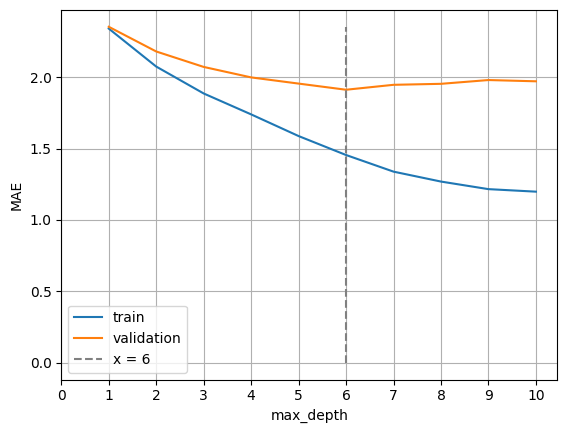

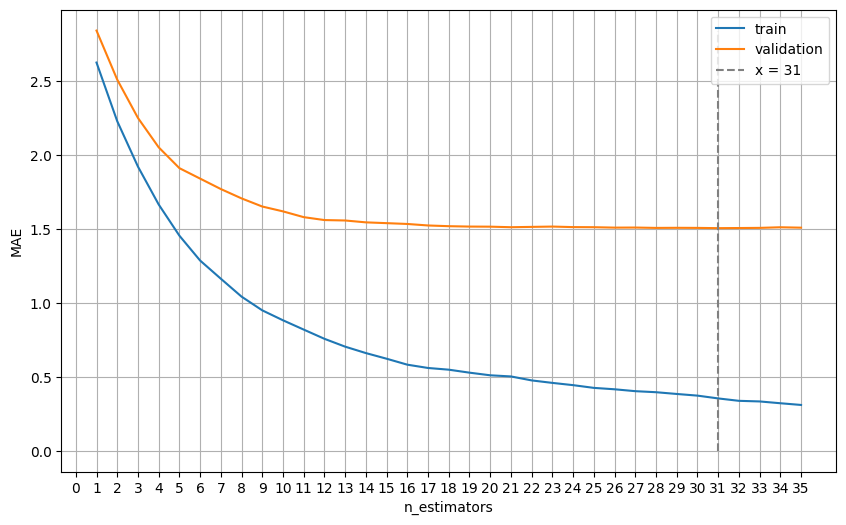

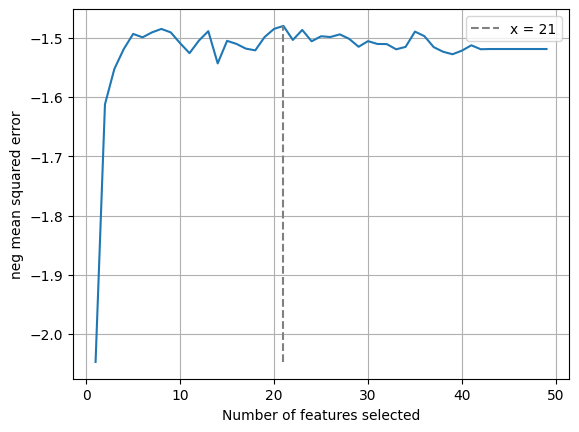

max_depth:  6
Number of estimators:  31
Selected_features:  Index(['ndmi', 'ndvi_std', 'lst_day', 'lst_night', 'acc_rainfall_2week',
       'acc_rainfall_jan', 'lst_jan_day_mean', 'lst_feb_day_mean',
       'lst_mar_day_mean', 'lst_apr_day_mean', 'lst_jan_night_mean',
       'lst_feb_night_mean', 'lst_mar_night_mean', 'DISTANCE_TO_COAST',
       'landcover', 'days_distance', 'mosq_sum_month',
       'mosq_sum_month_previous_year', 'mosq_sum_year',
       'mosq_sum_previous_2weeks', 'previous_mosq_measure'],
      dtype='object')


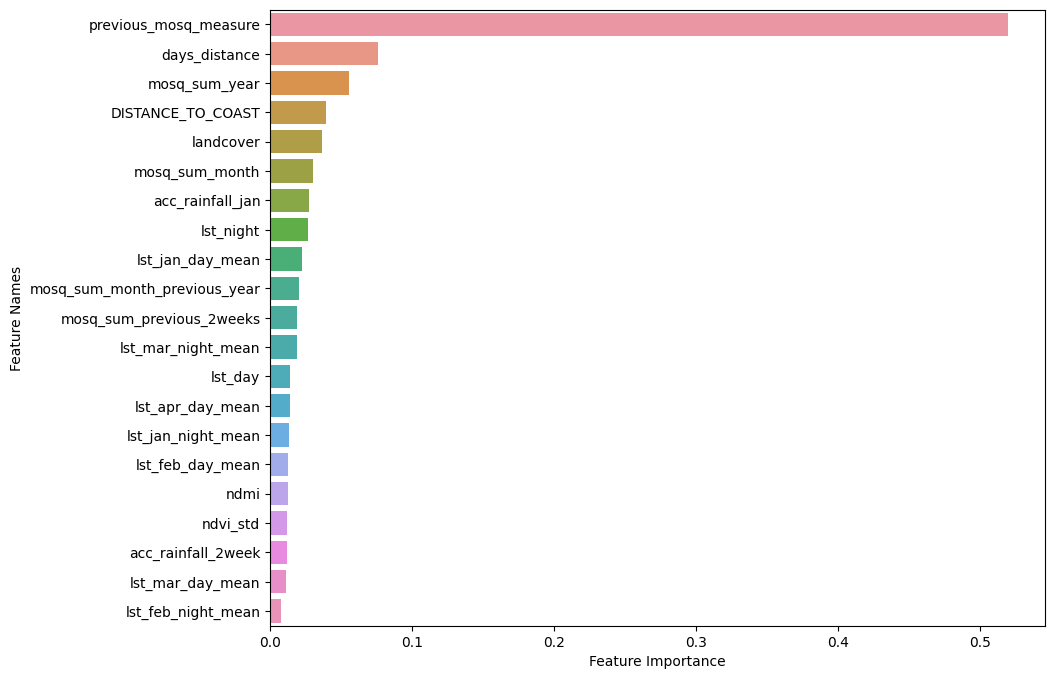

MAE on train set:  0.3934942287513116
min prediction: 0.0
max prediction: 9.0

MAE on test set:  1.225108225108225
Error <= 3: 92.21 %
min prediction: 0.0
max prediction: 9.0


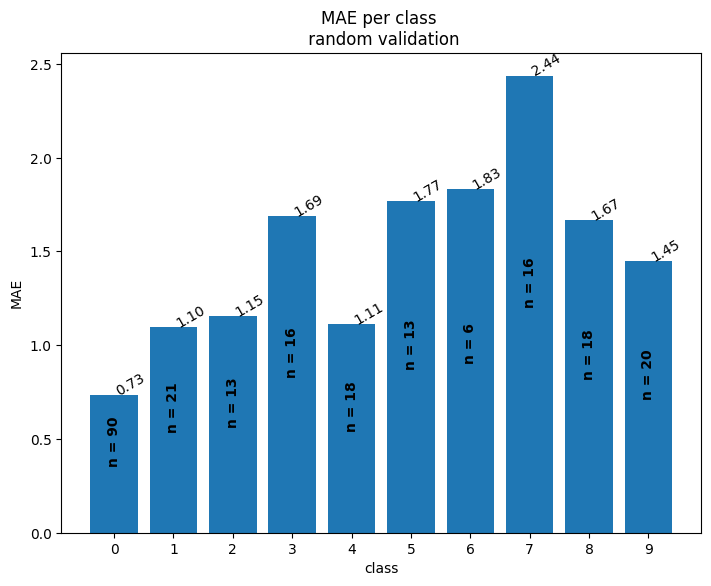

-----------|class error-MAE| difference-----------
mean: 0.38507020757020755
std: 0.2620284192824125
coefficient of variation (std/mean): 0.6804692082927201

----------normalized difference-------------
mean: 0.3899445139951469
std: 0.26534523471636706
coefficient of variation (std/mean): 0.68046920829272


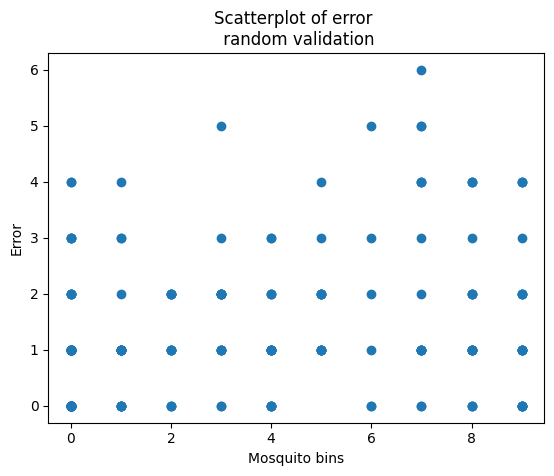

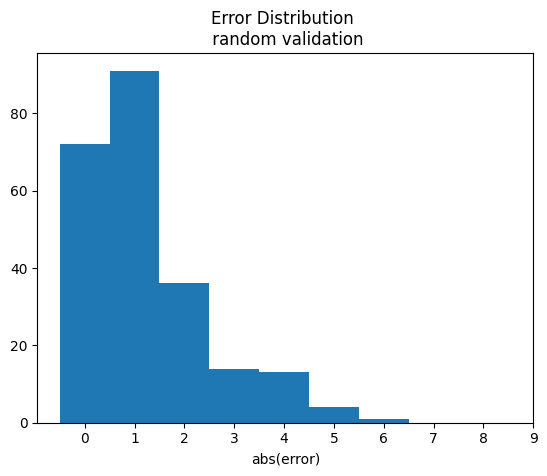

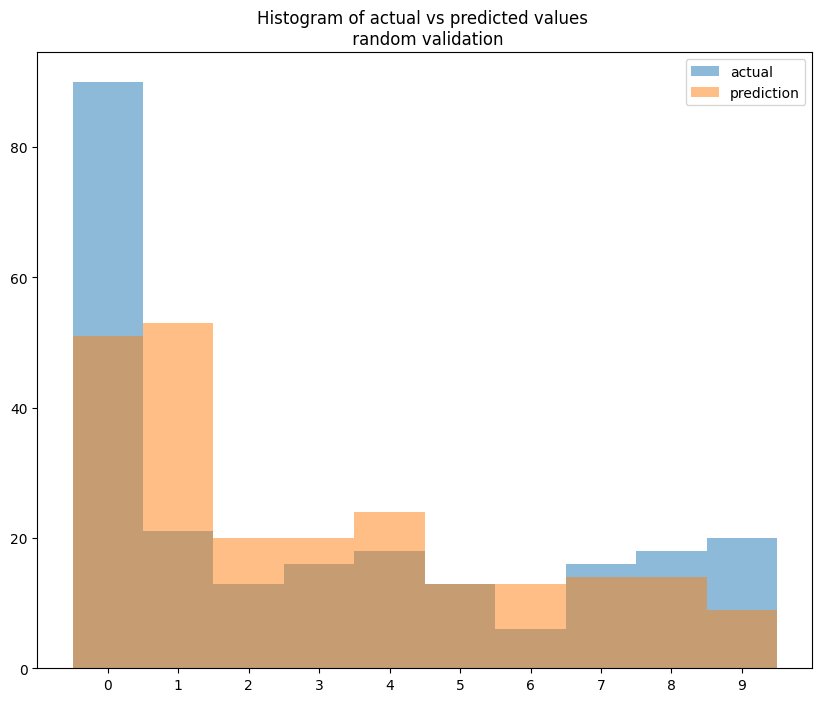

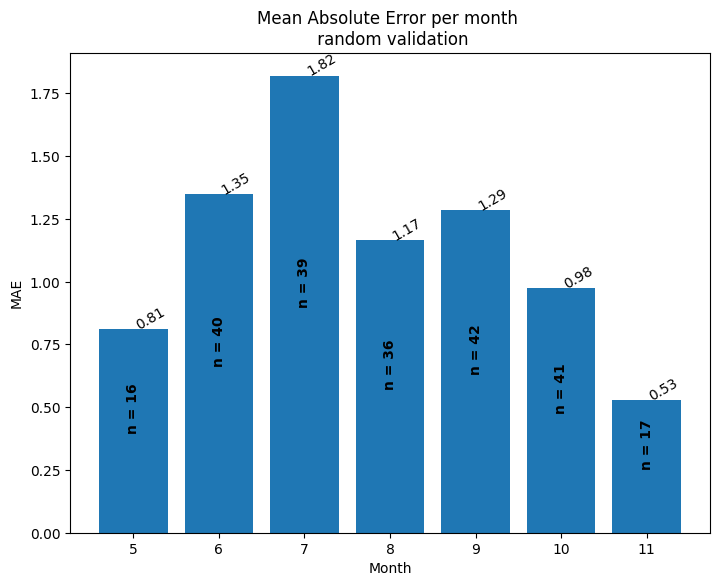

In [8]:
test_model_random_split(data, model, filepath = '', date_col = date_col, case='', fi = True, export=exp)

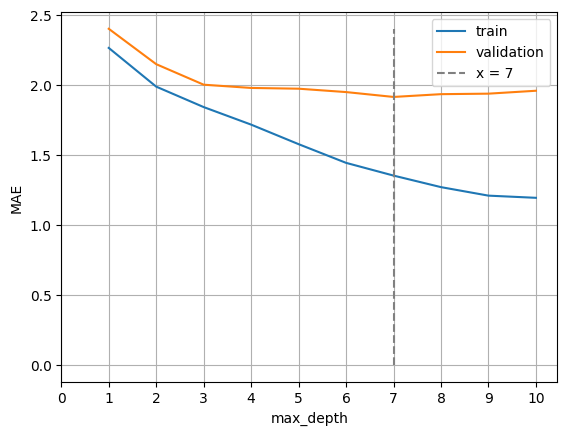

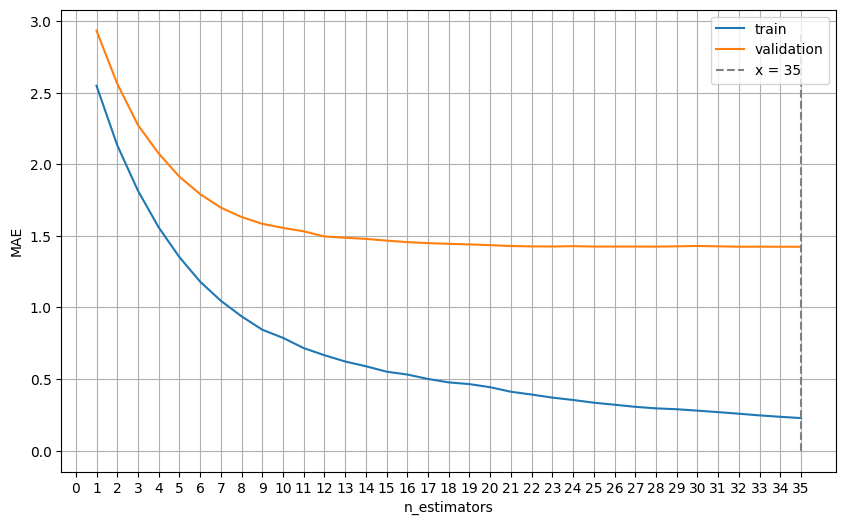

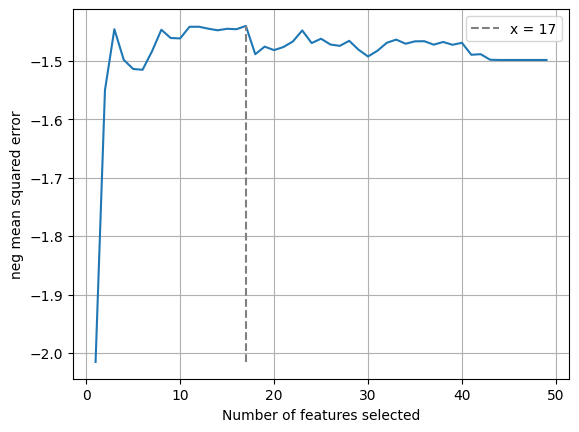

max_depth:  7
Number of estimators:  35
Selected_features:  Index(['ndwi', 'lst_night', 'acc_rainfall_jan', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean',
       'DISTANCE_TO_COAST', 'DISTANCE_TO_RIVER', 'FLOW_ACCU_200m', 'landcover',
       'days_distance', 'mosq_sum_month', 'mosq_sum_month_previous_year',
       'mosq_sum_year', 'mosq_sum_previous_2weeks', 'previous_mosq_measure'],
      dtype='object')
MAE on train set:  0.24632670700086431
min prediction: 0.0
max prediction: 9.0

MAE on test set:  1.4062229904926533
Error <= 3: 90.75 %
min prediction: 0.0
max prediction: 9.0


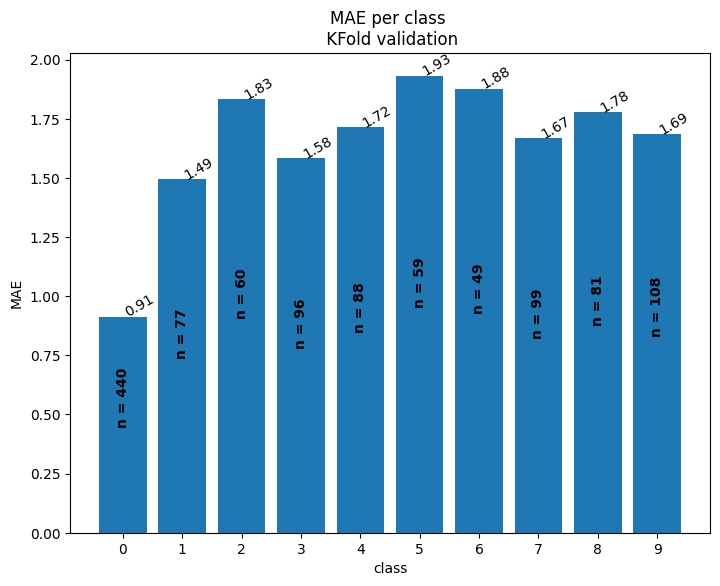

-----------|class error-MAE| difference-----------
mean: 0.17944465699308315
std: 0.2121860078492589
coefficient of variation (std/mean): 1.1824593242552648

----------normalized difference-------------
mean: 0.23257719016777526
std: 0.27501306712297574
coefficient of variation (std/mean): 1.1824593242552648


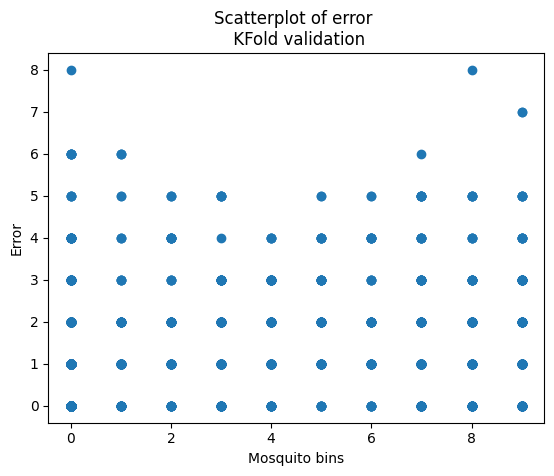

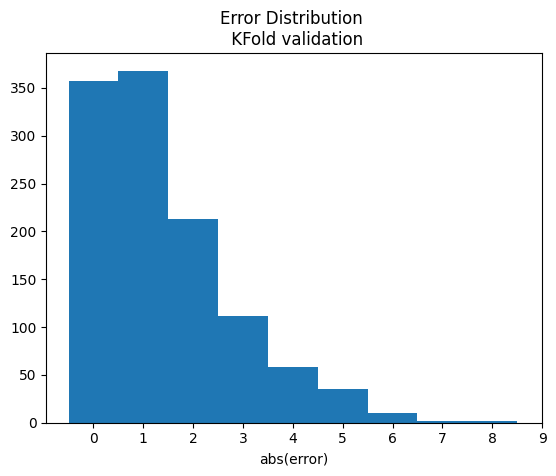

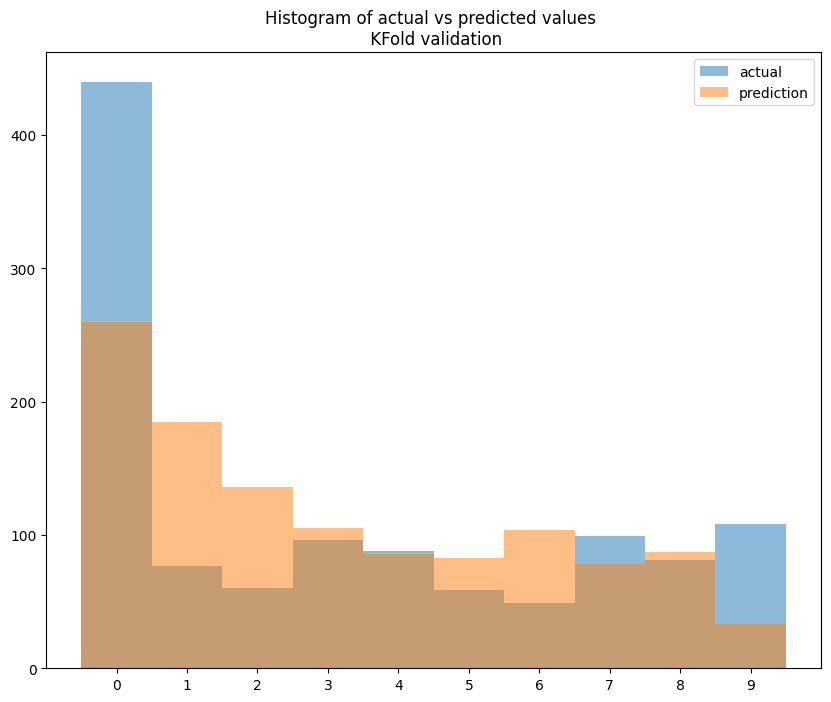

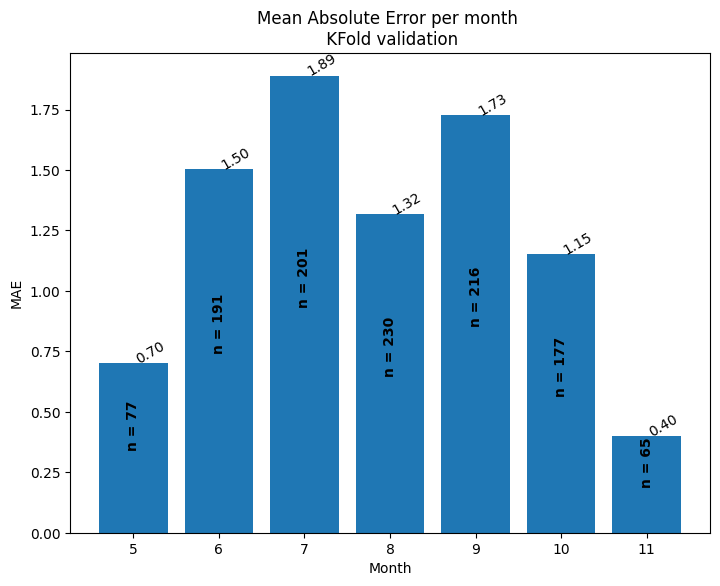

In [9]:
train_model_KFold(data, model, date_col=date_col)

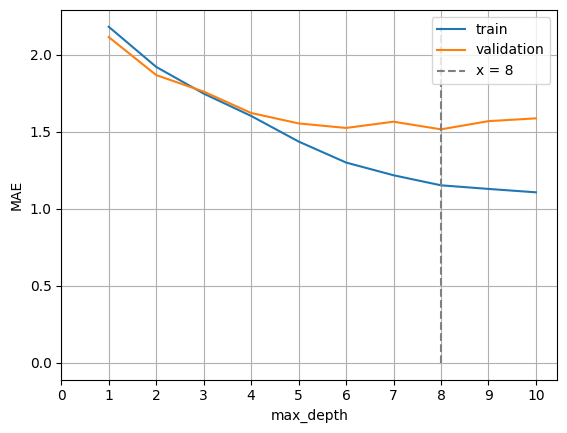

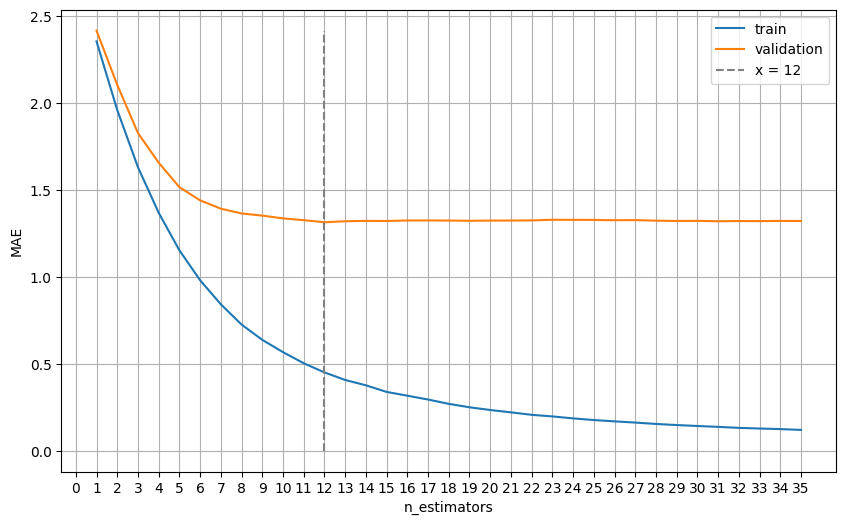

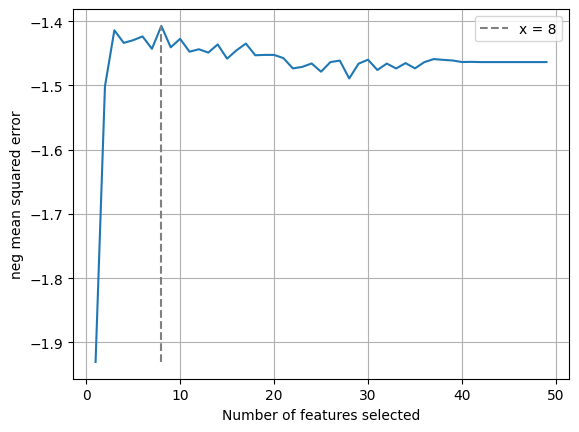

max_depth:  8
Number of estimators:  12
Selected_features:  Index(['acc_rainfall_jan', 'DISTANCE_TO_COAST', 'days_distance',
       'mosq_sum_month', 'mosq_sum_month_previous_year', 'mosq_sum_year',
       'mosq_sum_previous_2weeks', 'previous_mosq_measure'],
      dtype='object')
2021
MAE on train set:  0.6338952972493345
min prediction: 0.0
max prediction: 8.0

MAE on test set:  1.4539877300613497
Error <= 3: 88.96 %
min prediction: 0.0
max prediction: 8.0


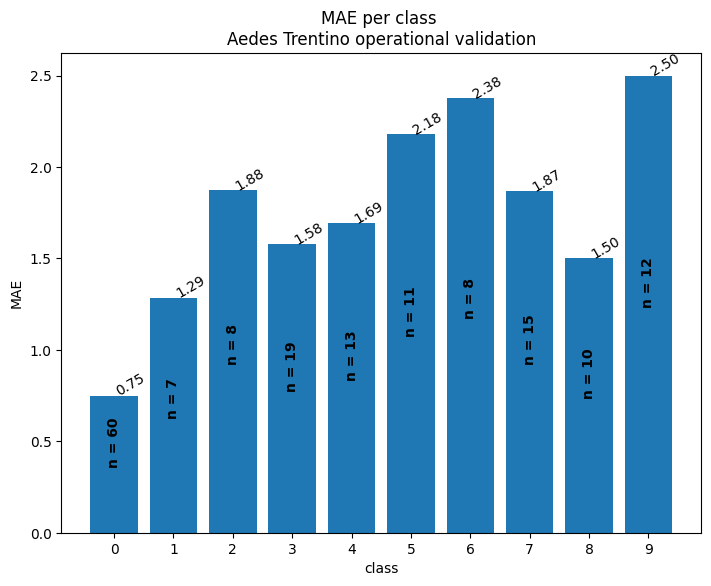

-----------|class error-MAE| difference-----------
mean: 0.7394545805072121
std: 0.49783176115670097
coefficient of variation (std/mean): 0.6732418383495907

----------normalized difference-------------
mean: 0.42254547457554975
std: 0.2844752920895434
coefficient of variation (std/mean): 0.6732418383495908


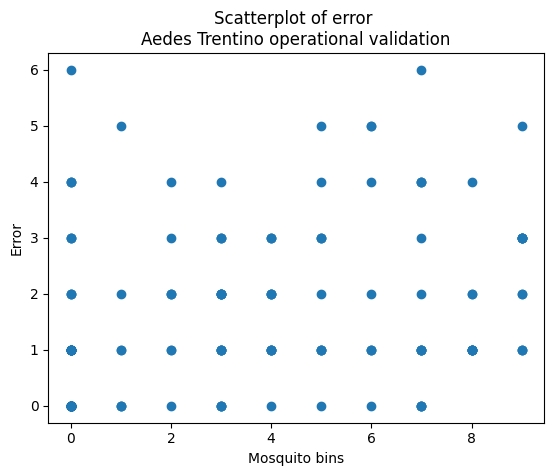

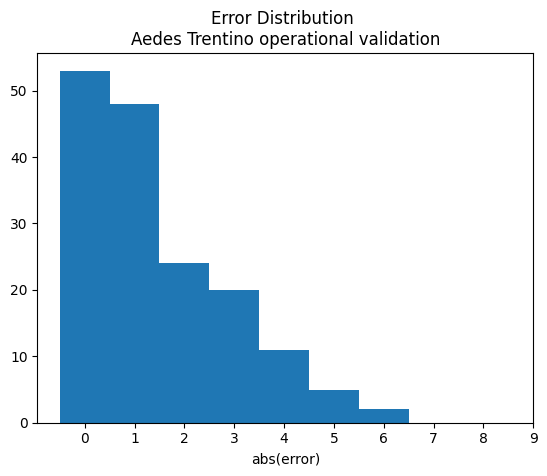

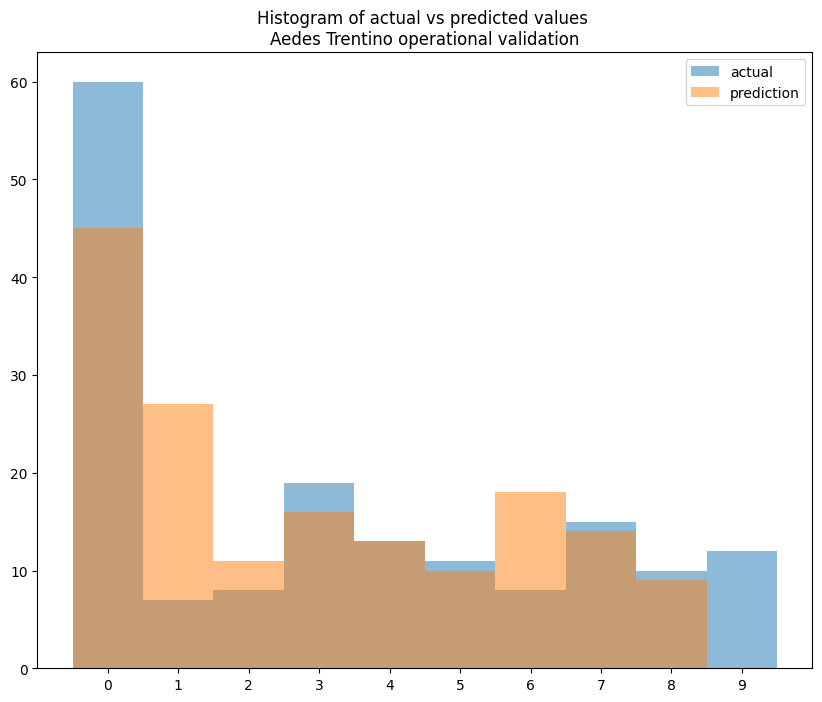

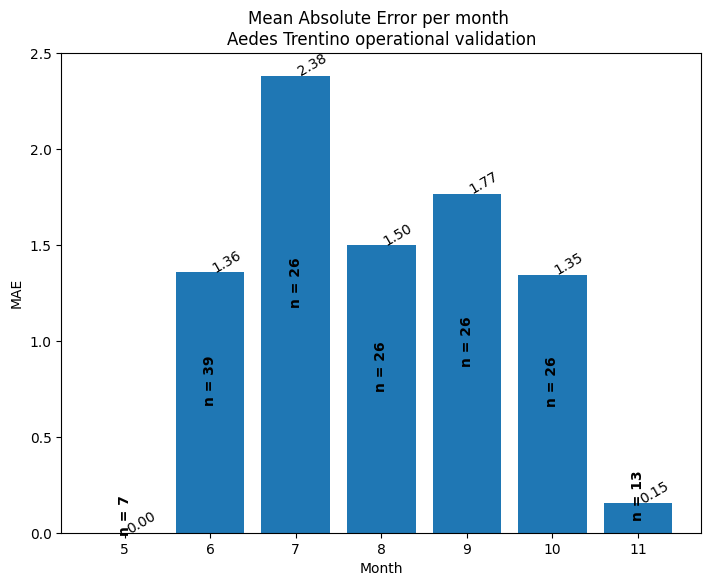

2022
MAE on train set:  0.6338952972493345
min prediction: 0.0
max prediction: 8.0

MAE on test set:  2.450980392156863
Error <= 3: 74.51 %
min prediction: 0.0
max prediction: 8.0


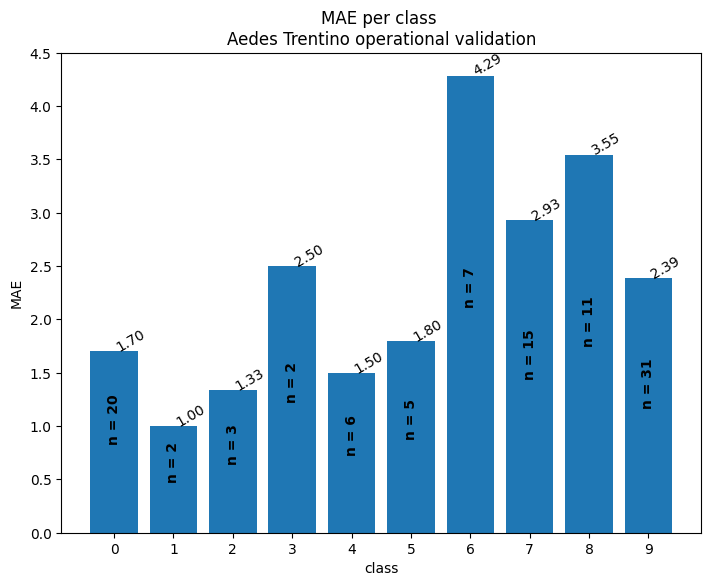

-----------|class error-MAE| difference-----------
mean: 0.8318265605362379
std: 0.5455720453367088
coefficient of variation (std/mean): 0.655872355151782

----------normalized difference-------------
mean: 0.4381222418358341
std: 0.2873522665972471
coefficient of variation (std/mean): 0.655872355151782


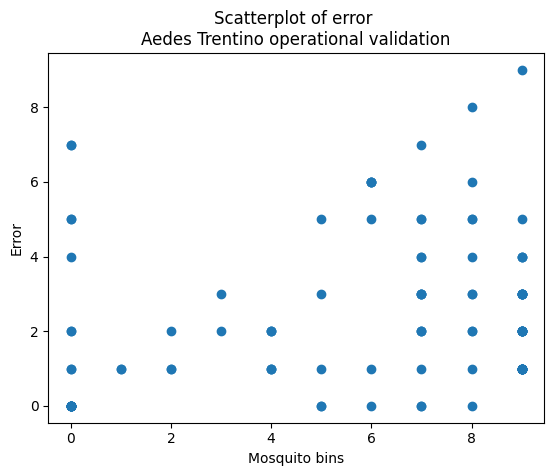

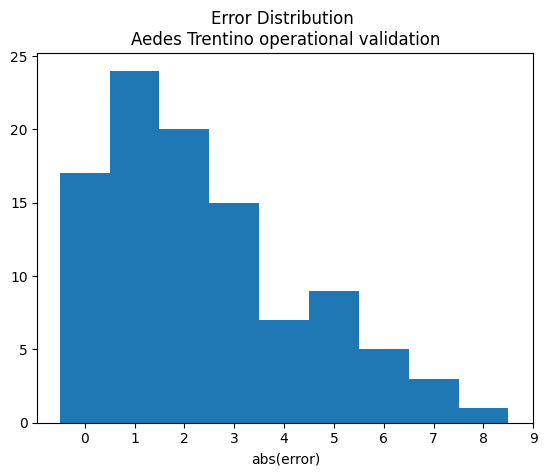

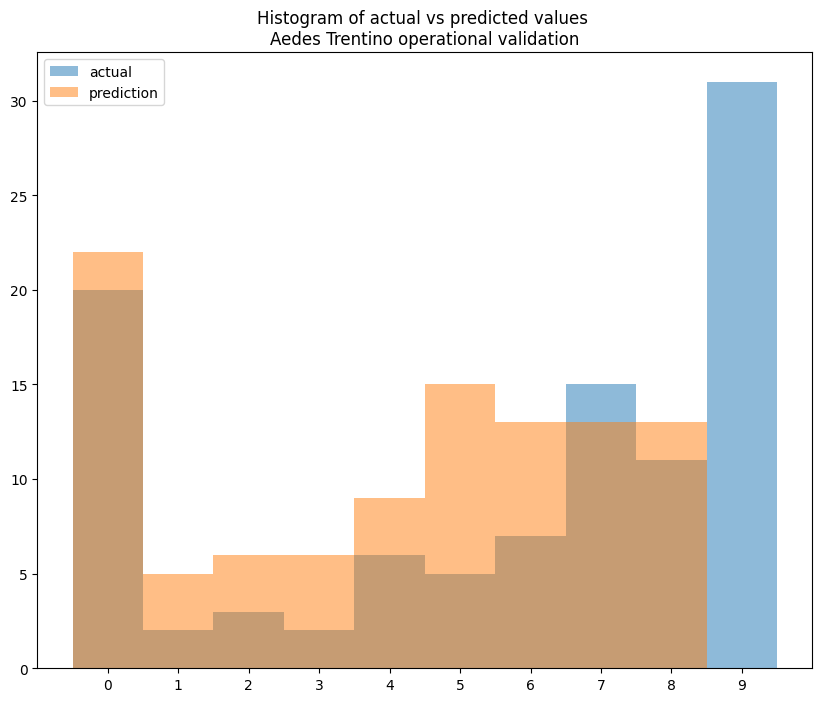

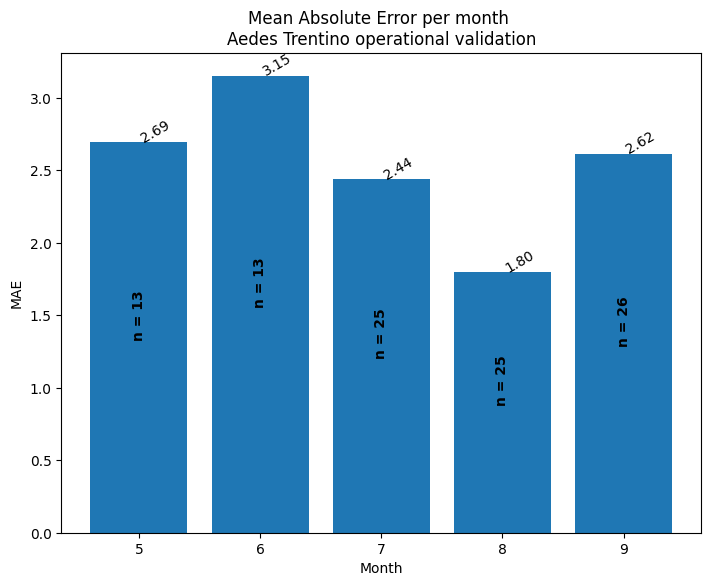

In [10]:
operational_validation(data, model, filepath = path, date_col = date_col,
                       date = '2021-01-01', case = case_title, export= exp)